<h1> HubMap - Hacking the Kidney </h1>
<h3> Goal - Mapping the human body at function tissue unit level - detect crypts FTUs in colon </h3>

Implementation of Kaggle Notebook - Innovation Prize Winner - Deep Flash2 <br>
Description - Use 5 fold models to predict on test image masks <br>
Input - models, test images, sample_submission.csv  <br>
Output - submission_df2_generalized.csv (rle for test images) <br>

<b>How to use?</b><br> 
Change the basepath to where your data lives and you're good to go. <br>

Link to the original notebook - https://www.kaggle.com/matjes/hubmap-deepflash2-submission


<h6> Step 1 - Import useful libraries </h6>

In [1]:
import sys
import cv2, torch, gc, rasterio
import torch.nn.functional as F
import deepflash2.tta as tta
import matplotlib.pyplot as plt
import pandas as pd, numpy as np
import segmentation_models_pytorch as smp
from pathlib import Path
from rasterio.windows import Window
from torch.utils.data import Dataset, DataLoader
from scipy .ndimage.filters import gaussian_filter
from tqdm.notebook import tqdm
import glob

import warnings
warnings.filterwarnings("ignore")

<h6> Step 2 - Helper functions </h6>

In [2]:
#https://www.kaggle.com/bguberfain/memory-aware-rle-encoding
#with transposed mask
def rle_encode_less_memory(img):
    #the image should be transposed
    pixels = img.T.flatten()
    
    # This simplified method requires first and last pixel to be zero
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)

def load_model_weights(model, file, strict=True):
    state = torch.load(file, map_location='cpu')
    stats = state['stats']
    model_state = state['model']
    model.load_state_dict(model_state, strict=strict)
    return model, stats

# from https://github.com/MIC-DKFZ/nnUNet/blob/2fade8f32607220f8598544f0d5b5e5fa73768e5/nnunet/network_architecture/neural_network.py#L250
def _get_gaussian(patch_size, sigma_scale=1. / 8) -> np.ndarray:
    tmp = np.zeros(patch_size)
    center_coords = [i // 2 for i in patch_size]
    sigmas = [i * sigma_scale for i in patch_size]
    tmp[tuple(center_coords)] = 1
    gaussian_importance_map = gaussian_filter(tmp, sigmas, 0, mode='constant', cval=0)
    gaussian_importance_map = gaussian_importance_map / np.max(gaussian_importance_map) * 1
    gaussian_importance_map = gaussian_importance_map.astype(np.float32)

    # gaussian_importance_map cannot be 0, otherwise we may end up with nans!
    gaussian_importance_map[gaussian_importance_map == 0] = np.min(
        gaussian_importance_map[gaussian_importance_map != 0])

    return gaussian_importance_map

In [3]:
# Some code adapted from https://www.kaggle.com/iafoss/hubmap-pytorch-fast-ai-starter-sub
class HubmapDataset(Dataset):
    'HubmapDataset class that does not load the full tiff files.'
    def __init__(self, file, stats, scale=3, shift=.8, output_shape=(512,512), s_th = 40):
        
        self.mean, self.std = stats
        self.scale = scale
        self.shift = shift
        self.output_shape = output_shape
        self.input_shape = tuple(int(t*scale) for t in self.output_shape)      
        self.s_th = s_th #saturation blancking threshold
        self.p_th = 1000*(self.output_shape[0]//256)**2 #threshold for the minimum number of pixels

        identity = rasterio.Affine(1, 0, 0, 0, 1, 0)
        self.data = rasterio.open(file, transform = identity, num_threads='all_cpus')
        if self.data.count != 3:
            subdatasets = self.data.subdatasets
            self.layers = []
            if len(subdatasets) > 0:
                for i, subdataset in enumerate(subdatasets, 0):
                    self.layers.append(rasterio.open(subdataset))
            
        # Tiling
        self.slices = []
        self.out_slices = []
        self.out_data_shape = tuple(int(x//self.scale) for x in self.data.shape)
        start_points = [o//2 for o in self.output_shape]
        end_points = [(s - st) for s, st in zip(self.out_data_shape, start_points)]
        n_points = [int(s//(o*self.shift))+1 for s, o in zip(self.out_data_shape, self.output_shape)]
        center_points = [np.linspace(st, e, num=n, endpoint=True, dtype=np.int64) for st, e, n in zip(start_points, end_points, n_points)]
        for cx in center_points[1]:
            for cy in center_points[0]:
                # Calculate output slices for whole image
                slices = tuple(slice(int((c*self.scale - o/2).clip(0, s)), int((c*self.scale + o/2).clip(max=s)))
                                 for (c, o, s) in zip((cy, cx), self.input_shape, self.data.shape))
                self.slices.append(slices)
                
                out_slices = tuple(slice(int((c - o/2).clip(0, s)), int((c + o/2).clip(max=s)))
                                 for (c, o, s) in zip((cy, cx), self.output_shape, self.out_data_shape))
                self.out_slices.append(out_slices)
                

    def __len__(self):
        return len(self.slices)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        slices = self.slices[idx]
        if self.data.count == 3: # normal
            img = self.data.read([1, 2, 3], 
                window=Window.from_slices(*slices)
            )
            img = np.moveaxis(img, 0, -1)
        else: # with subdatasets/layers
            img = np.zeros((*self.input_shape, 3), dtype=np.uint8)
            for fl in range(3):
                img[:, :, fl] = self.layers[fl].read(
                    window=Window.from_slices(*slices)
                )
        
        if self.scale!=1:
            img = cv2.resize(img, self.output_shape, interpolation = cv2.INTER_AREA)
        
        #check for empty imges
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h,s,v = cv2.split(hsv)
        if (s>self.s_th).sum() <= self.p_th or img.sum() <= self.p_th:
            # Remove if idx=-1
            idx = -1
        
        img = (img/255.0 - self.mean)/self.std
        img = img.transpose(2, 0, 1).astype('float32')
        
        return torch.from_numpy(img), idx
    
class Model_pred:
    'Class for prediction with multiple models'
    def __init__(self, models, use_tta=True, batch_size=32):
        self.models = models
        self.bs = batch_size
        self.tfms = [tta.HorizontalFlip(), tta.VerticalFlip()] if use_tta else []
        
    def predict(self, ds):
        #rasterio cannot be used with multiple workers
        dl = DataLoader(ds, self.bs, num_workers=0, shuffle=False, pin_memory=True)
        
        # Create zero arrays
        pred = np.zeros(ds.out_data_shape, dtype='float32')
        merge_map = np.zeros(ds.out_data_shape, dtype='float32')
        
        # Gaussian weights
        gw_numpy = _get_gaussian(ds.output_shape)
        gw = torch.from_numpy(gw_numpy).to(device)
        
        with torch.no_grad():
            for images, idxs in tqdm(iter(dl), total=len(dl)):
                if ((idxs>=0).sum() > 0): #exclude empty images
                    images = images[idxs>=0].to(device)
                    idxs = idxs[idxs>=0]
                    merger = tta.Merger()
                    for t in tta.Compose(self.tfms):
                        aug_images = t.augment_image(images)
                        model_merger = tta.Merger()
                        for model in self.models:
                            out = model(aug_images)
                            out = F.softmax(out, dim=1)
                            model_merger.append(out)
                        out = t.deaugment_mask(model_merger.result())
                        merger.append(out)
            
                    # Apply gaussian weigthing
                    batch_smx = merger.result()*gw.view(1,1,*gw.shape)
                    batch_smx = [x for x in batch_smx.permute(0,2,3,1).cpu().numpy()]

                    for smx, idx in zip(batch_smx, idxs):
                        slcs = ds.out_slices[idx]
                        # Only using positive class here
                        pred[slcs] += smx[...,1]
                        merge_map[slcs] += gw_numpy

        pred /= merge_map
        return pred

<h6> Step 3 - Set configuration </h6>

In [11]:
class CONFIG():
    path = r'C:\Users\soodn\Downloads\Naveksha\Kaggle HuBMAP\Scripts\5. DeepFlash'
    # data paths
    data_path = r'C:\Users\soodn\Downloads\Naveksha\Kaggle HuBMAP\Data\colon-data-reprocessed'
    # Local train on all data
    model_path = path+'/models'
    #model_path = Path('../input/hubmap-deepflash2-train')
    
    # zoom factor (e.g., 3 means downscaling from 1536 to 512)
    scale = 3 
    # tile shift for prediction
    shift = 0.8 
    tile_shape = (512, 512)

    # pytorch model (https://github.com/qubvel/segmentation_models.pytorch)
    encoder_name = "efficientnet-b2"
    encoder_weights = None
    in_channels = 3
    classes = 2
    
    # dataloader 
    batch_size = 32
    
    # test time augmentation
    tta = True
    # prediction threshold
    threshold = 0.5
    
cfg = CONFIG()

<h6> Step 4 - Read models </h6>

In [12]:
# Sample submissions for ids
df_sample = pd.read_csv(cfg.data_path+'/sample_submission.csv', index_col = "id")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Models (see https://github.com/qubvel/segmentation_models.pytorch)
MODELS = [name for name in glob.glob(cfg.model_path+'/*.pth')]
print(f'Found {len(MODELS)} models', *MODELS)

models = []
for i, m_path in enumerate(MODELS):
    #state_dict = torch.load(path,map_location=torch.device('cpu'))
    model = smp.Unet(encoder_name=cfg.encoder_name, 
                     encoder_weights=cfg.encoder_weights, 
                     in_channels=cfg.in_channels, 
                     classes=cfg.classes)
    model, stats = load_model_weights(model, m_path)
    model.float()
    model.eval()
    model.to(device)
    models.append(model)

mp = Model_pred(models, use_tta=cfg.tta, batch_size=cfg.batch_size)

Found 5 models C:\Users\soodn\Downloads\Naveksha\Kaggle HuBMAP\Scripts\5. DeepFlash/models\unet_efficientnet-b2_0.pth C:\Users\soodn\Downloads\Naveksha\Kaggle HuBMAP\Scripts\5. DeepFlash/models\unet_efficientnet-b2_1.pth C:\Users\soodn\Downloads\Naveksha\Kaggle HuBMAP\Scripts\5. DeepFlash/models\unet_efficientnet-b2_2.pth C:\Users\soodn\Downloads\Naveksha\Kaggle HuBMAP\Scripts\5. DeepFlash/models\unet_efficientnet-b2_3.pth C:\Users\soodn\Downloads\Naveksha\Kaggle HuBMAP\Scripts\5. DeepFlash/models\unet_efficientnet-b2_4.pth


<h6> Step 5: Make prediction </h6>

  0%|          | 0/2 [00:00<?, ?it/s]

###### File CL_HandE_1234_B004_bottomleft ######
C:\Users\soodn\Downloads\Naveksha\Kaggle HuBMAP\Data\colon-data-reprocessed/test/CL_HandE_1234_B004_bottomleft.tiff
Predicting...


  0%|          | 0/1 [00:00<?, ?it/s]

Rezising...
Plotting


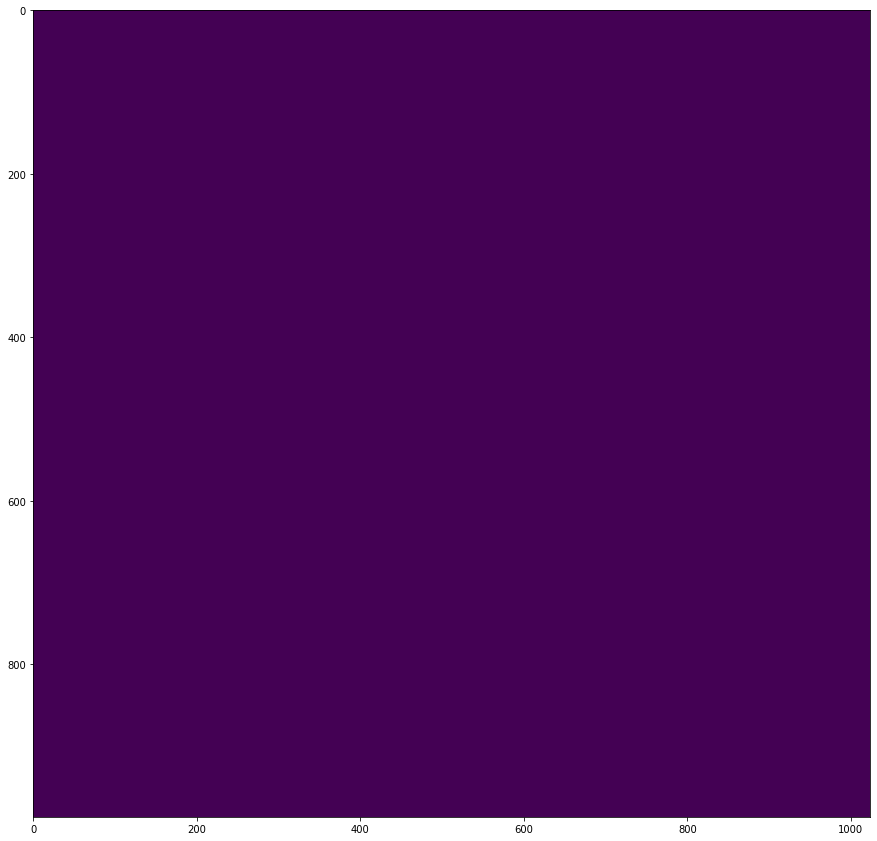

###### File HandE_B005_CL_b_RGB_bottomleft ######
C:\Users\soodn\Downloads\Naveksha\Kaggle HuBMAP\Data\colon-data-reprocessed/test/HandE_B005_CL_b_RGB_bottomleft.tiff
Predicting...


  0%|          | 0/1 [00:00<?, ?it/s]

Rezising...
Plotting


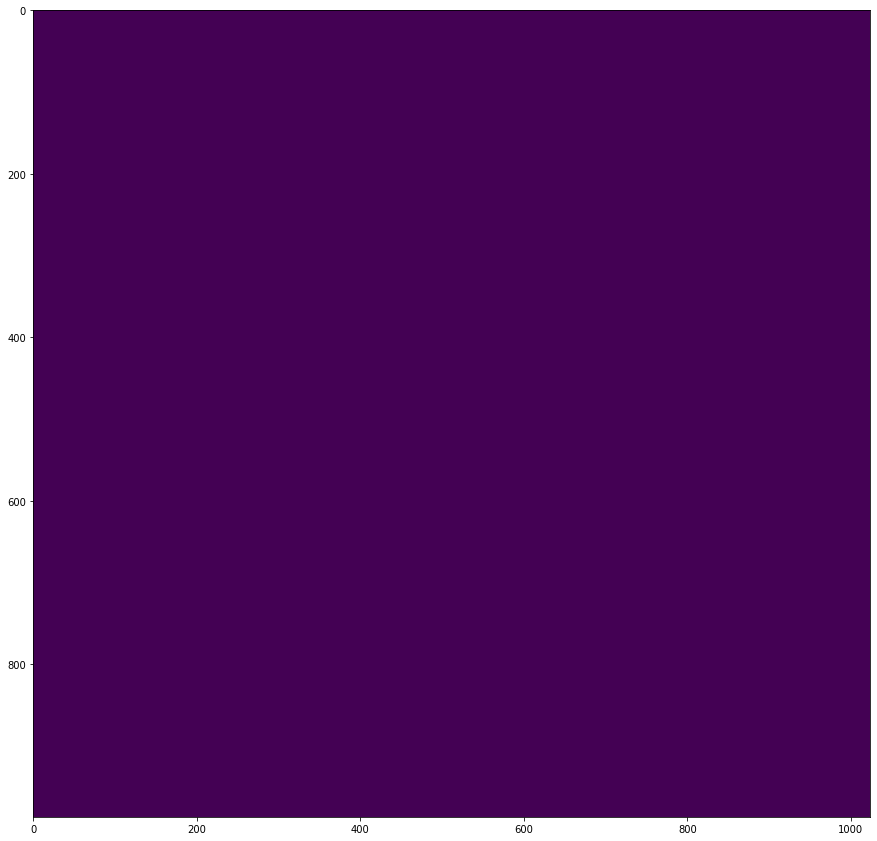

In [15]:
names,preds = [],[]
for idx,row in tqdm(df_sample.iterrows(),total=len(df_sample)):
    
    print(f'###### File {idx} ######')
    f = cfg.data_path+f'/test/{idx}.tiff'
    print (f)
    ds = HubmapDataset(f, stats, scale=cfg.scale, shift=cfg.shift, output_shape=cfg.tile_shape)
    
    print('Predicting...')   
    pred = mp.predict(ds)
       
    print('Rezising...')
    shape = ds.data.shape
    pred = cv2.resize((pred*255).astype('uint8'), (shape[1], shape[0]))
    
    pred = (pred>cfg.threshold*255).astype(np.uint8)
    
    #convert to rle
    #https://www.kaggle.com/bguberfain/memory-aware-rle-encoding
    rle = rle_encode_less_memory(pred)
    names.append(idx)
    preds.append(rle)
    
    print('Plotting')
    fig, ax = plt.subplots(figsize=(15,15))
    ax.imshow(cv2.resize(pred, (1024, 1024*shape[0]//shape[1])))
    plt.show()
    
    del pred
    gc.collect()

In [16]:
df = pd.DataFrame({'id':names,'predicted':preds})
df.to_csv('output/submission_colon_generalized.csv',index=False)
df.head()

,id,predicted
0,CL_HandE_1234_B004_bottomleft,
1,HandE_B005_CL_b_RGB_bottomleft,
